In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

data_1lead = [x for x in data_1lead if x[1] != '~']

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:01<00:00, 7896.31it/s]
8249it [00:03, 2688.81it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 943.53it/s] 


In [7]:
3318/3

1106.0

In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
Name: count, dtype: int64

In [9]:
pd.Series([x[1] for x in data_12lead]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

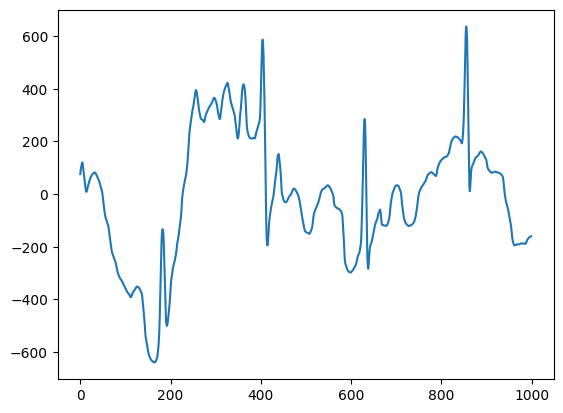

In [10]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[19][0])

In [11]:
value_counts = dataset_1lead.get_value_counts(count=3)
weights = [sum(value_counts)/x for x in value_counts]
# weights[labelmap['~']] = weights[labelmap['N']]

In [12]:
value_counts

[2415, 758, 5076]

# Training

## Single-Lead Model

Fold 1
Epoch:10/200 AVG Training Loss:2.52086 AVG Test Loss:2.36003 AVG Training F1 51.07 % AVG Test F1 56.02 %
Epoch:20/200 AVG Training Loss:2.23626 AVG Test Loss:2.08059 AVG Training F1 59.00 % AVG Test F1 63.96 %
Epoch:30/200 AVG Training Loss:2.17135 AVG Test Loss:1.98382 AVG Training F1 60.41 % AVG Test F1 68.37 %
Epoch:40/200 AVG Training Loss:2.10640 AVG Test Loss:1.98680 AVG Training F1 62.63 % AVG Test F1 64.62 %
Epoch:50/200 AVG Training Loss:2.03930 AVG Test Loss:1.93329 AVG Training F1 64.37 % AVG Test F1 65.80 %
Epoch:60/200 AVG Training Loss:2.00301 AVG Test Loss:1.98311 AVG Training F1 65.42 % AVG Test F1 67.02 %
Epoch:70/200 AVG Training Loss:1.96974 AVG Test Loss:1.88797 AVG Training F1 66.07 % AVG Test F1 69.42 %
Epoch:80/200 AVG Training Loss:1.98183 AVG Test Loss:1.97044 AVG Training F1 64.25 % AVG Test F1 68.94 %
Epoch:90/200 AVG Training Loss:1.98089 AVG Test Loss:1.99196 AVG Training F1 65.63 % AVG Test F1 69.20 %
Epoch:100/200 AVG Training Loss:2.01039 AVG Test

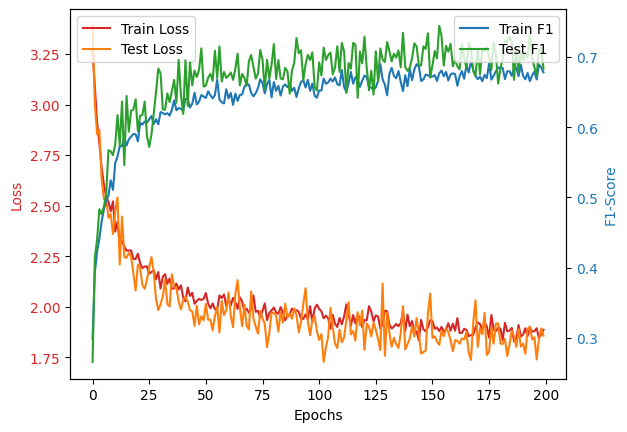

Overall results of 5 fold cross-validation
Train: Average loss 1.9826933205127717, average F1 score 68.13126353744887
Test: Average loss 1.9218454636060276, average F1 score 70.8632044160554


In [20]:
# Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.lr = 0.002
trainparams.n_epochs = 200

history, confusion_list = train_kfold_model(dataset_1lead, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history,trainparams=trainparams)

In [14]:
def plt_c(cm):
    labelmap2 = {x:y for y,x in labelmap.items()}

    # Converting the confusion matrix to fraction
    cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm_fraction)

    # Creating a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_fraction, annot=True, fmt=".2f", cmap='Blues', xticklabels=[labelmap2[i] for i in range(4)], yticklabels=[labelmap2[i] for i in range(4)])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (as fraction)')
    plt.show()

In [15]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:2.57569 AVG Test Loss:2.47680 AVG Training F1 50.89 % AVG Test F1 54.46 %
Epoch:20/200 AVG Training Loss:2.48510 AVG Test Loss:2.37518 AVG Training F1 51.96 % AVG Test F1 56.12 %
Epoch:30/200 AVG Training Loss:2.34738 AVG Test Loss:2.19098 AVG Training F1 57.13 % AVG Test F1 59.02 %
Epoch:40/200 AVG Training Loss:2.19913 AVG Test Loss:2.12336 AVG Training F1 61.54 % AVG Test F1 62.41 %
Epoch:50/200 AVG Training Loss:2.09813 AVG Test Loss:2.01770 AVG Training F1 64.26 % AVG Test F1 67.71 %
Epoch:60/200 AVG Training Loss:2.05798 AVG Test Loss:1.92637 AVG Training F1 64.15 % AVG Test F1 67.17 %
Epoch:70/200 AVG Training Loss:2.00520 AVG Test Loss:1.82787 AVG Training F1 65.27 % AVG Test F1 68.25 %
Epoch:80/200 AVG Training Loss:1.99125 AVG Test Loss:1.81405 AVG Training F1 65.41 % AVG Test F1 69.59 %
Epoch:90/200 AVG Training Loss:2.01104 AVG Test Loss:1.83147 AVG Training F1 66.33 % AVG Test F1 68.77 %
Epoch:100/200 AVG Training Loss:1.94478 AVG Test Loss:1

## Transfer

Fold 1
Epoch:10/100 AVG Training Loss:1.09662 AVG Test Loss:1.09763 AVG Training F1 37.58 % AVG Test F1 16.66 %
Epoch:20/100 AVG Training Loss:1.08836 AVG Test Loss:1.09499 AVG Training F1 37.40 % AVG Test F1 34.61 %
Epoch:30/100 AVG Training Loss:1.07717 AVG Test Loss:1.06581 AVG Training F1 39.66 % AVG Test F1 46.12 %
Epoch:40/100 AVG Training Loss:0.87527 AVG Test Loss:0.91326 AVG Training F1 61.38 % AVG Test F1 55.88 %
Epoch:50/100 AVG Training Loss:0.64885 AVG Test Loss:0.79883 AVG Training F1 71.05 % AVG Test F1 61.99 %
Epoch:60/100 AVG Training Loss:0.46170 AVG Test Loss:0.74783 AVG Training F1 81.59 % AVG Test F1 66.12 %
Epoch:70/100 AVG Training Loss:0.36525 AVG Test Loss:0.73278 AVG Training F1 86.43 % AVG Test F1 66.48 %
Epoch:80/100 AVG Training Loss:0.27468 AVG Test Loss:0.78433 AVG Training F1 91.09 % AVG Test F1 67.22 %
Epoch:90/100 AVG Training Loss:0.22509 AVG Test Loss:0.77720 AVG Training F1 90.40 % AVG Test F1 68.29 %
Early stopping triggered after epoch 91
Fold 2
E

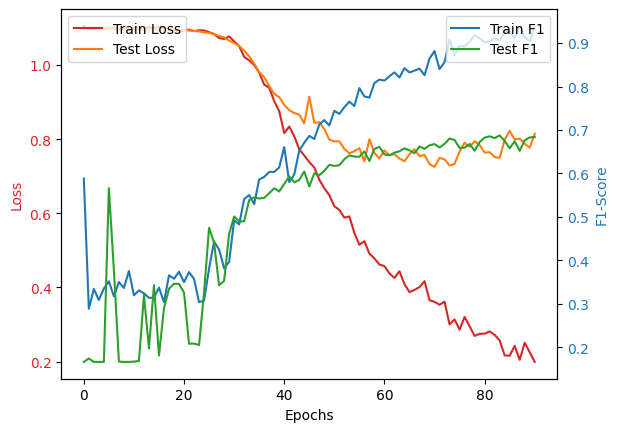

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.29052293946345653, average F1 score 90.40983460531406
Test: Average loss 0.8323720385630926, average F1 score 70.06480071220457


In [16]:
## Control training - no transfer
## k-fold with leave-(k-1)-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.66611 AVG Test Loss:0.55461 AVG Training F1 70.29 % AVG Test F1 78.69 %
Epoch:20/100 AVG Training Loss:0.51607 AVG Test Loss:0.46363 AVG Training F1 78.43 % AVG Test F1 81.88 %
Epoch:30/100 AVG Training Loss:0.47651 AVG Test Loss:0.44130 AVG Training F1 79.52 % AVG Test F1 79.98 %
Epoch:40/100 AVG Training Loss:0.44120 AVG Test Loss:0.45416 AVG Training F1 82.52 % AVG Test F1 81.34 %
Epoch:50/100 AVG Training Loss:0.41414 AVG Test Loss:0.43708 AVG Training F1 82.80 % AVG Test F1 80.09 %
Epoch:60/100 AVG Training Loss:0.38165 AVG Test Loss:0.43350 AVG Training F1 83.65 % AVG Test F1 81.77 %
Early stopping triggered after epoch 63
Fold 2
Epoch:10/100 AVG Training Loss:0.77571 AVG Test Loss:0.79352 AVG Training F1 66.45 % AVG Test F1 60.94 %
Epoch:20/100 AVG Training Loss:0.53637 AVG Test Loss:0.48972 AVG Training F1 77.50 % AVG Test F1 77.54 %
Epoch:30/100 AVG Training Loss:0.48176 AVG Test Loss:0.50986 AVG Training F1 80.34 % AVG Test F1 76.45 %
E

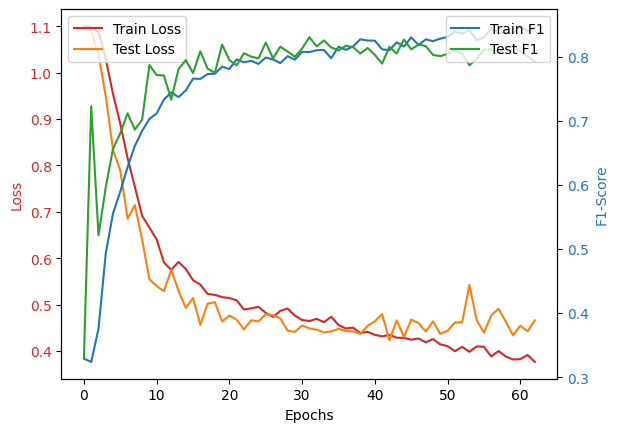

Overall results of 10 fold cross-validation with leave-1-out
Train: Average loss 0.345813484924535, average F1 score 86.49039623016021
Test: Average loss 0.44212636947631834, average F1 score 83.6118393767051


In [17]:
## Control training - no transfer
## k-fold with leave-1-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=1
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.58780 AVG Test Loss:0.49662 AVG Training F1 79.01 % AVG Test F1 80.14 %
Epoch:20/100 AVG Training Loss:0.48213 AVG Test Loss:0.45237 AVG Training F1 85.17 % AVG Test F1 81.63 %
Early stopping triggered after epoch 23
Fold 2
Epoch:10/100 AVG Training Loss:0.56883 AVG Test Loss:0.52397 AVG Training F1 81.91 % AVG Test F1 76.19 %
Epoch:20/100 AVG Training Loss:0.44597 AVG Test Loss:0.46861 AVG Training F1 88.62 % AVG Test F1 80.24 %
Early stopping triggered after epoch 25
Fold 3
Epoch:10/100 AVG Training Loss:0.56933 AVG Test Loss:0.48955 AVG Training F1 77.80 % AVG Test F1 79.75 %
Epoch:20/100 AVG Training Loss:0.45514 AVG Test Loss:0.45208 AVG Training F1 87.29 % AVG Test F1 81.38 %
Early stopping triggered after epoch 26
Fold 4
Epoch:10/100 AVG Training Loss:0.53632 AVG Test Loss:0.47826 AVG Training F1 86.14 % AVG Test F1 79.40 %
Epoch:20/100 AVG Training Loss:0.41013 AVG Test Loss:0.46532 AVG Training F1 88.31 % AVG Test F1 81.07 %
Early stoppi

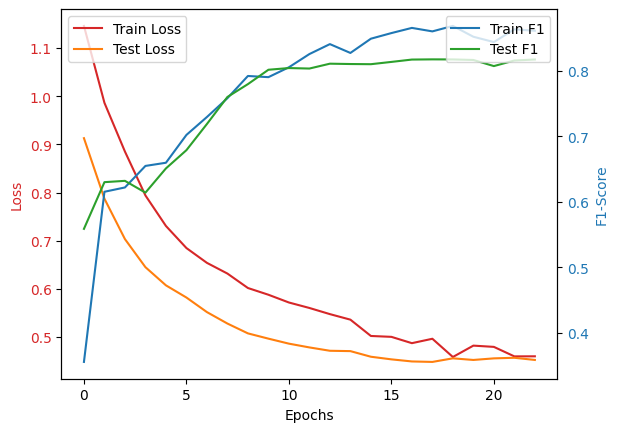

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.42265739540259045, average F1 score 90.01184550614674
Test: Average loss 0.4614801347255707, average F1 score 81.71594483829831


In [21]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=5

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [19]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer as well as allowing intermediate connections between LSTM1 and LSTM2

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

Fold 1
Epoch:10/200 AVG Training Loss:0.00887 AVG Test Loss:0.00621 AVG Training Acc 62.24 % AVG Test Acc 64.35 %
Epoch:20/200 AVG Training Loss:0.00737 AVG Test Loss:0.00568 AVG Training Acc 68.88 % AVG Test Acc 67.06 %
Epoch:30/200 AVG Training Loss:0.00651 AVG Test Loss:0.00527 AVG Training Acc 74.92 % AVG Test Acc 68.97 %
Epoch:40/200 AVG Training Loss:0.00586 AVG Test Loss:0.00527 AVG Training Acc 77.04 % AVG Test Acc 70.14 %
Epoch:50/200 AVG Training Loss:0.00512 AVG Test Loss:0.00537 AVG Training Acc 84.59 % AVG Test Acc 70.10 %
Epoch:60/200 AVG Training Loss:0.00502 AVG Test Loss:0.00492 AVG Training Acc 86.71 % AVG Test Acc 73.02 %
Epoch:70/200 AVG Training Loss:0.00487 AVG Test Loss:0.00500 AVG Training Acc 86.40 % AVG Test Acc 73.38 %
Epoch:80/200 AVG Training Loss:0.00434 AVG Test Loss:0.00515 AVG Training Acc 91.24 % AVG Test Acc 72.82 %
Early stopping triggered after epoch 87
Fold 2
Epoch:10/200 AVG Training Loss:0.00872 AVG Test Loss:0.00617 AVG Training Acc 67.37 % AVG 

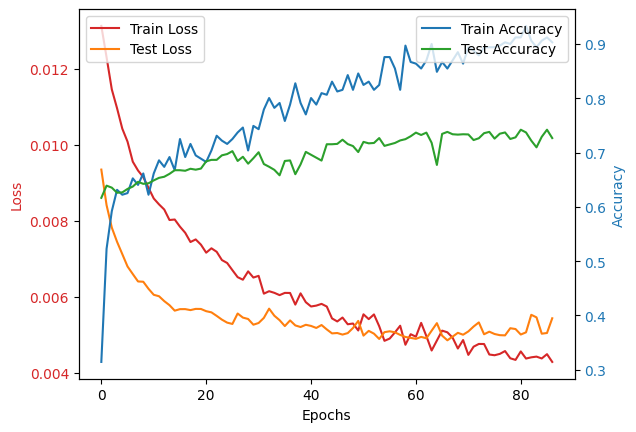

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0048697439999856, average accuracy 89.78460670476468
Test: Average loss 0.005758168469717858, average accuracy 73.13300704033173


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer and new LSTM layer

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)




##### decay rate 1e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0031394222757836323, average accuracy 92.2543042259673
Test: Average loss 0.005575405785830426, average accuracy 75.34325793553714



##### decay rate 2e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00365060051937096, average accuracy 92.10397481163325
Test: Average loss 0.0056262301620364705, average accuracy 75.40019813476168



##### decay rate 4e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003943431980226399, average accuracy 93.4603974811633
Test: Average loss 0.005629858633990846, average accuracy 75.86563207253761



##### decay rate 8e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00436789161980497, average accuracy 92.49444909547556
Test: Average loss 0.005634408243827259, average accuracy 74.37203658362394



##### decay rate 0.00016
Overall result

## Augmented Data

In [ ]:
control_dataset = WindowDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:03, 2480.05it/s]


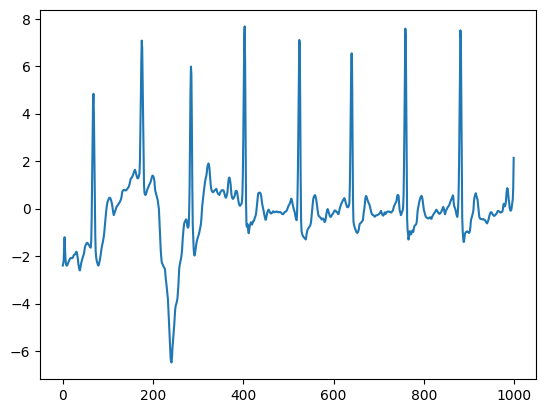

In [ ]:
waveform, label, rpeaks = control_dataset.__getitem__(0, return_rpeaks=True)
plt.plot(waveform.cpu())

In [ ]:
augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:03, 2276.40it/s]


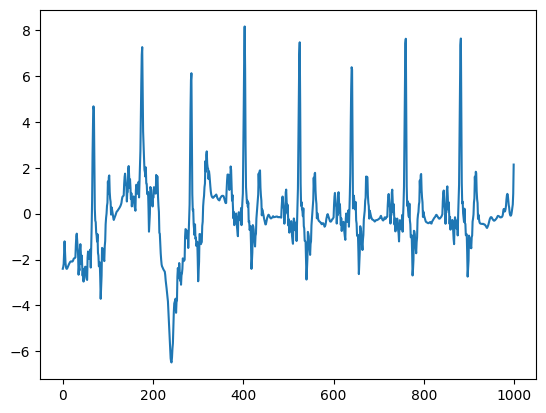

In [ ]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

In [ ]:
augment_dataset.__getitem__(0)[0].shape

torch.Size([1000, 12])

8528it [00:03, 2341.29it/s]


Fold 1
Epoch:10/100 AVG Training Loss:0.00732 AVG Test Loss:0.00600 AVG Training Acc 70.42 % AVG Test Acc 69.11 %
Epoch:20/100 AVG Training Loss:0.00678 AVG Test Loss:0.00584 AVG Training Acc 71.60 % AVG Test Acc 70.87 %
Epoch:30/100 AVG Training Loss:0.00638 AVG Test Loss:0.00586 AVG Training Acc 73.94 % AVG Test Acc 71.51 %
Epoch:40/100 AVG Training Loss:0.00623 AVG Test Loss:0.00608 AVG Training Acc 74.41 % AVG Test Acc 71.44 %
Early stopping triggered after epoch 45


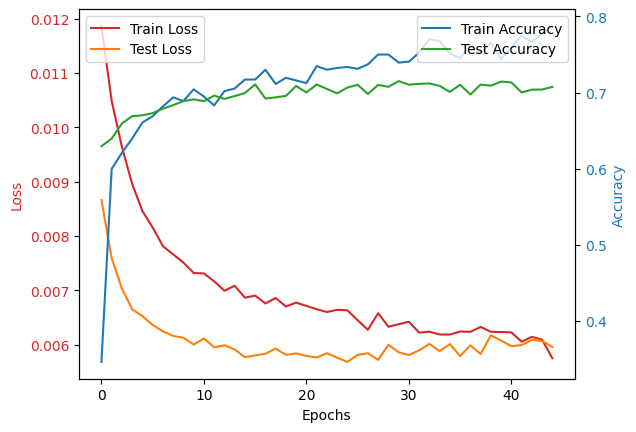

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.005752154289276947, average accuracy 78.75586854460094
Test: Average loss 0.005959530456604095, average accuracy 71.50859822824388


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(augment_dataset, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)